In [1]:

import pandas as pd
import os
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import gseapy
import sys
import argparse
import yaml
import os
import json

# Perform PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Plot PCA results
import matplotlib.pyplot as plt
import seaborn as sns

## Cleaning

In [2]:
def align_and_filter(protein_df, binary_series):
    """
    Joins protein data and binary label, drops samples with label == -1.
    """
    df = protein_df.join(binary_series.rename("label"))
    no_label_bool = df["label"] == -1
    print(f"Filtering out {no_label_bool.sum()}/{len(df)} samples with irrelevant labels.")
    df = df[~no_label_bool]
    
    return df.drop(columns="label"), df["label"]

In [3]:
def filter_features_by_missingness(X, threshold=0.2, verbose=True):
    """
    Remove protein features with too many missing values.

    Args:
        X (pd.DataFrame): samples x proteins.
        threshold (float): maximum fraction of missing values allowed (e.g., 0.2 = 20%).
        verbose (bool): print number of features removed.

    Returns:
        pd.DataFrame: filtered X with fewer columns.
    """
    missing_fraction = X.isna().mean()
    keep_cols = missing_fraction[missing_fraction <= threshold].index
    if verbose:
        dropped = len(X.columns) - len(keep_cols)
        print(f"Filtered out {dropped}/{len(X.columns)} proteins with >{threshold*100:.0f}% missing values.")
    return X[keep_cols]

In [4]:
def impute_missing_values(X, method="mean"):
    """
    Impute missing values in X.

    Args:
        X (pd.DataFrame): samples x proteins.
        method (str): "mean", "median", or "zero".

    Returns:
        pd.DataFrame: imputed X.
    """
    if method == "mean":
        return X.fillna(X.mean())
    elif method == "median":
        return X.fillna(X.median())
    elif method == "zero":
        return X.fillna(0)
    else:
        raise ValueError("Invalid imputation method. Choose from 'mean', 'median', or 'zero'.")

## Loading

In [5]:
def prepare_categorical_variable(clinical_df, var, drop_values=None, verbose=True):
    """
    Prepares a categorical variable by mapping unique values to integers starting from 0.

    Args:
        clinical_df (pd.DataFrame): clinical data with sample index.
        var (str): variable name.
        drop_values (list): list of values to treat as NaN and exclude from mapping.
        verbose (bool): print debug info.

    Returns:
        tuple: (pd.Series with integer-encoded values, dict mapping integers to original values)
    """
    assert isinstance(clinical_df, pd.DataFrame), "clinical_df must be a DataFrame"
    assert var in clinical_df.columns, f"'{var}' not found in clinical_df"

    series = clinical_df[var].copy()

    if drop_values is not None:
        series = series.replace(drop_values, pd.NA)

    unique_vals = series.dropna().unique()
    value_to_int = {val: i for i, val in enumerate(unique_vals)}
    int_to_value = {i: val for val, i in value_to_int.items()}
    mapped_series = series.map(value_to_int)
    mapped_series = mapped_series.dropna().astype(int)


    if verbose:
        print(f"{var} unique values: {len(unique_vals)}")
        if drop_values:
            print(f"Dropped values: {drop_values}")
        print("Mapping created:")
        for i, val in int_to_value.items():
            print(f"\t{i}: {repr(val)}")


    return mapped_series, int_to_value


## PCA

In [6]:
def apply_pca(X):

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X)

    pca = PCA(n_components=min(X.shape[0], X.shape[1]))  # Use min to avoid dimension issues
    pca_result = pca.fit_transform(scaled_data)

    print(f"Original data shape: {X.shape}")
    print(f"PCA result shape: {pca_result.shape}")
    print(f"Explained variance ratio (first 10 components): {pca.explained_variance_ratio_[:10]}")
    print(f"Cumulative explained variance (first 10 components): {pca.explained_variance_ratio_[:10].cumsum()}")

    return pca, pca_result

## Plot

In [7]:
def plot_pca(pca, pca_result, X,y, int_to_value, title = None, out_file=None):


    # Create PCA DataFrame with correct dimensions
    pca_df = pd.DataFrame(
        pca_result,
        index=X.index,
        columns=[f'PC{i+1}' for i in range(pca_result.shape[1])]
    )

    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: PCA scatter plot (PC1 vs PC2)
    ax1 = axes[0]

    # Get unique labels and create a color map
    unique_labels = sorted(set(y))
    colors = plt.cm.Set1(range(len(unique_labels)))  # Use Set1 colormap for distinct colors
    color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

    # Create scatter plot with colors based on labels
    for label in unique_labels:
        mask = [y_val == label for y_val in y]
        ax1.scatter(pca_df['PC1'][mask], pca_df['PC2'][mask], 
                c=[color_map[label]], alpha=0.7, label=f'Label {label}')

    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    if not title:
        title = "PCA: PC1 vs PC2"
    ax1.set_title(title)
    ax1.grid(True, alpha=0.3)

    # Add legend with original mapping values
    legend_labels = []
    for label in unique_labels:
        # original_keys = [key for key, value in mapping.items() if value == label]
        # legend_label = f"{', '.join(original_keys)} (Label {label})"
        legend_label = int_to_value[label]
        legend_labels.append(legend_label)

    # Update legend
    handles, _ = ax1.get_legend_handles_labels()
    ax1.legend(handles, legend_labels)

    # Plot 2: Explained variance plot
    ax2 = axes[1]
    n_components_to_show = min(20, len(pca.explained_variance_ratio_))
    components = range(1, n_components_to_show + 1)
    variance_ratios = pca.explained_variance_ratio_[:n_components_to_show]
    cumulative_variance = variance_ratios.cumsum()

    ax2.bar(components, variance_ratios, alpha=0.7, label='Individual')
    ax2.plot(components, cumulative_variance, 'ro-', label='Cumulative')
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Explained Variance Ratio')
    ax2.set_title('PCA Explained Variance')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if out_file:
        plt.savefig(out_file)
    plt.show()

    # Print summary statistics
    print(f"\nPCA Summary:")
    print(f"Number of unique labels: {len(unique_labels)}")
    print(f"Label distribution: {dict(pd.Series(y.map(int_to_value)).value_counts().sort_index())}")
    print(f"Total variance explained by first 2 components: {pca.explained_variance_ratio_[:2].sum():.2%}")
    print(f"Total variance explained by first 5 components: {pca.explained_variance_ratio_[:5].sum():.2%}")
    print(f"Total variance explained by first 10 components: {pca.explained_variance_ratio_[:10].sum():.2%}")

## Pipeline

In [8]:
def pca_pipeline(protein_df, clinical_df, var, missingness_thresh, imputation_method, out_file=None):
    print("Using clinical variable:", var)
    cat_var, int_to_value = prepare_categorical_variable(
        clinical_df,
        var=var,
        #mapping=mapping,
        )
    
    X, y = align_and_filter(protein_df, cat_var)
    X = filter_features_by_missingness(X, threshold=missingness_thresh)
    X = impute_missing_values(X, method=imputation_method)


    print("Starting PCA...")
    pca, pca_result = apply_pca(X)

    
    plot_pca(pca, pca_result, X, y, int_to_value, f"PCA: {var}", out_file)
    
    


## main()

In [9]:
def main(config_path):
    from datetime import datetime


    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

    # Required
    protein_group_csv = config["protein_group_csv"]
    clinical_csv = config["clinical_csv"]
    var = config["var"]
    output_dir = config["output_dir"]

    # Optional
    missingness_thresh = config.get("missingness_thresh", 0.2)
    imputation_method = config.get("imputation_method", "mean")

    # Create timestamped subdirectory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    timestamped_dir = os.path.join(output_dir, timestamp)
    os.makedirs(timestamped_dir, exist_ok=True)

    # Load input files
    protein_group_df = pd.read_csv(protein_group_csv, index_col=0)
    clinical_df = pd.read_csv(clinical_csv, index_col=0)

    out_file = f"{timestamped_dir}/{var}_PCA.png"
    pca_pipeline(protein_group_df, clinical_df, var, missingness_thresh, imputation_method, out_file=out_file)

    # Save copy of config file
    config_copy_path = os.path.join(timestamped_dir, "config.yaml")
    with open(config_copy_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)
    print(f"Saved config copy to: {config_copy_path}")



### execution

Using clinical variable: Condition
Condition unique values: 4
Mapping created:
	0: '1-C'
	1: '2-SC'
	2: '3-A'
	3: '4-S'
Filtering out 0/240 samples with irrelevant labels.
Filtered out 2278/8320 proteins with >20% missing values.
Starting PCA...
Original data shape: (240, 6042)
PCA result shape: (240, 240)
Explained variance ratio (first 10 components): [0.42110395 0.10615343 0.04303472 0.02887988 0.01780562 0.01564329
 0.01442811 0.01194777 0.01132956 0.00900174]
Cumulative explained variance (first 10 components): [0.42110395 0.52725737 0.5702921  0.59917198 0.61697759 0.63262088
 0.64704899 0.65899677 0.67032632 0.67932807]


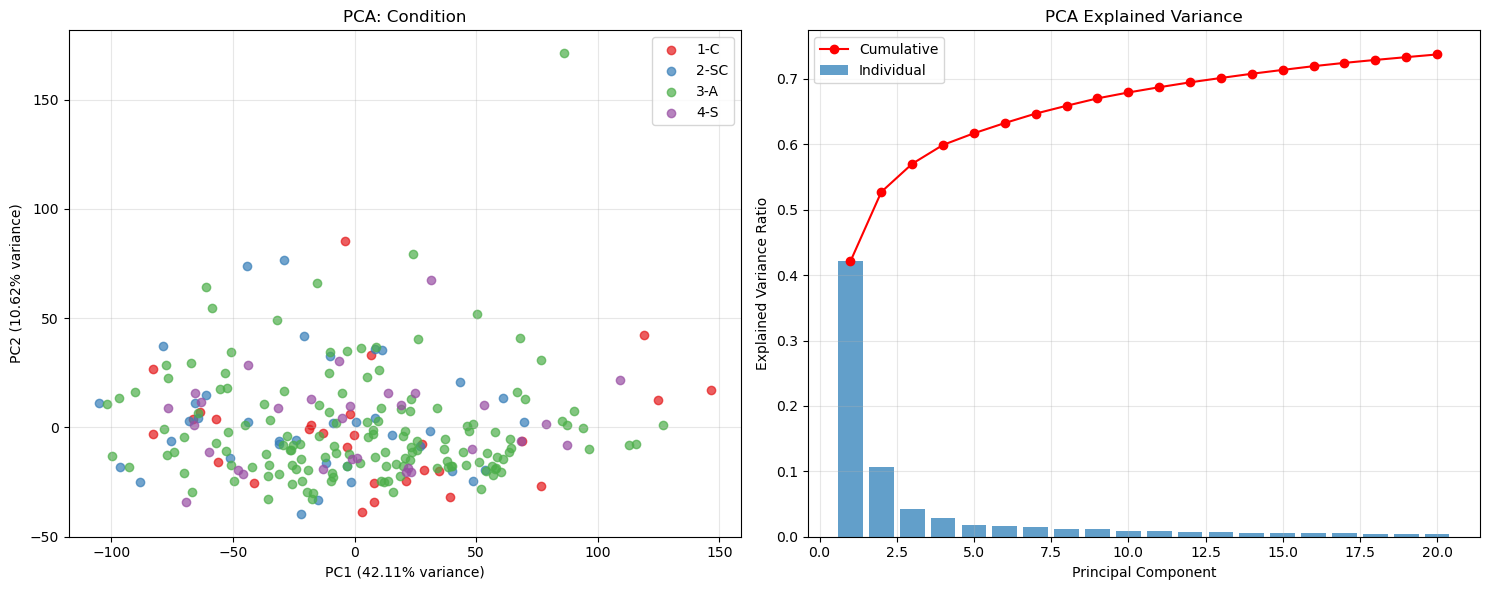


PCA Summary:
Number of unique labels: 4
Label distribution: {'1-C': 28, '2-SC': 37, '3-A': 145, '4-S': 30}
Total variance explained by first 2 components: 52.73%
Total variance explained by first 5 components: 61.70%
Total variance explained by first 10 components: 67.93%
Saved config copy to: pca_results\20250716_113021\config.yaml


In [82]:
if __name__ == "__main__" and 'ipykernel' not in sys.modules:  # CLI mode
    parser = argparse.ArgumentParser(description="Pathway Enrichment Pipeline using gseapy")
    parser.add_argument("--config_path", type=str, required=True,
                        help="Path to config file")
    
    args = parser.parse_args()
    main(args.config_path)

if 'ipykernel' in sys.modules:  # Notebook mode
    config = {
        "protein_group_csv": "protein_group_df.csv",
        "clinical_csv": "clinical_df.csv",
        "output_dir": "pca_results",

        # Optional settings
        "missingness_thresh": 0.2,
        "imputation_method": "mean",


        "var": 'Condition',

        }

    with open("config.yaml", "w") as f:
        yaml.dump(config, f, default_flow_style=False)

    main("config.yaml")

Using clinical variable: Condition
Condition unique values: 4
Mapping created:
	0: '1-C'
	1: '2-SC'
	2: '3-A'
	3: '4-S'
Filtering out 0/240 samples with irrelevant labels.
Filtered out 167/2142 proteins with >20% missing values.
Starting PCA...
Original data shape: (240, 1975)
PCA result shape: (240, 240)
Explained variance ratio (first 10 components): [0.37026355 0.07455484 0.07280127 0.03270181 0.02597894 0.02388614
 0.01627511 0.0131831  0.01154142 0.01053898]
Cumulative explained variance (first 10 components): [0.37026355 0.44481839 0.51761966 0.55032147 0.5763004  0.60018655
 0.61646165 0.62964475 0.64118617 0.65172515]


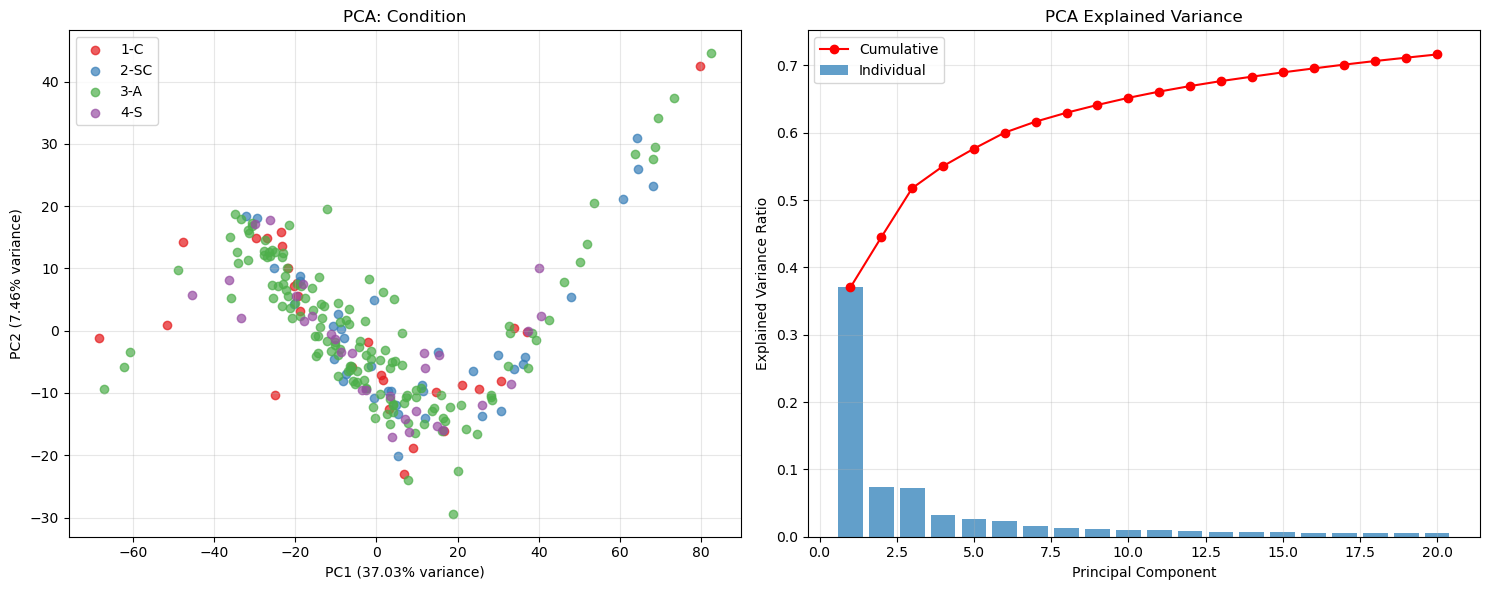


PCA Summary:
Number of unique labels: 4
Label distribution: {'1-C': 28, '2-SC': 37, '3-A': 145, '4-S': 30}
Total variance explained by first 2 components: 44.48%
Total variance explained by first 5 components: 57.63%
Total variance explained by first 10 components: 65.17%
Saved config copy to: Imputed_MatrixExport_NP_A\20250722_122328\config.yaml


In [29]:
main("Imputed_MatrixExport_NP_A.yaml")

Using clinical variable: Condition
Condition unique values: 4
Mapping created:
	0: '1-C'
	1: '2-SC'
	2: '3-A'
	3: '4-S'
Filtering out 0/240 samples with irrelevant labels.
Filtered out 631/3788 proteins with >20% missing values.
Starting PCA...
Original data shape: (240, 3157)
PCA result shape: (240, 240)
Explained variance ratio (first 10 components): [0.24057063 0.12246726 0.04321925 0.03511734 0.02614767 0.02205739
 0.02109688 0.01760354 0.01591821 0.01161221]
Cumulative explained variance (first 10 components): [0.24057063 0.36303789 0.40625714 0.44137448 0.46752216 0.48957954
 0.51067642 0.52827997 0.54419818 0.55581038]


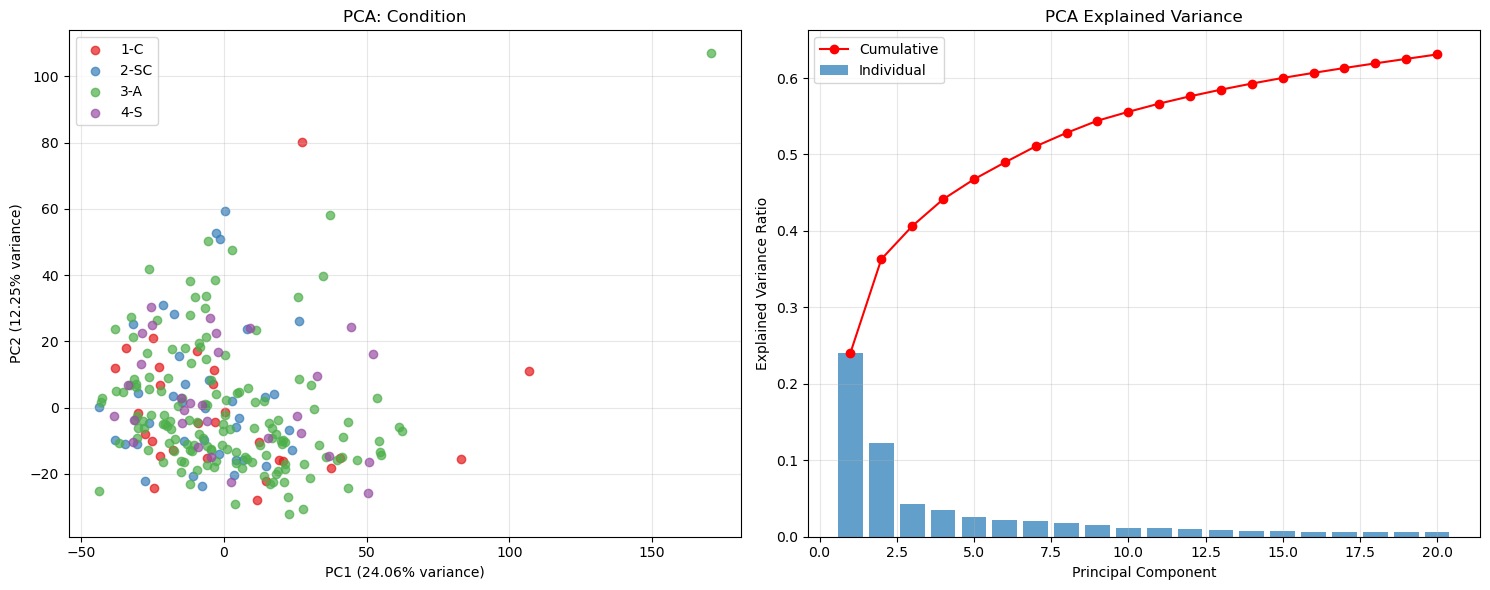


PCA Summary:
Number of unique labels: 4
Label distribution: {'1-C': 28, '2-SC': 37, '3-A': 145, '4-S': 30}
Total variance explained by first 2 components: 36.30%
Total variance explained by first 5 components: 46.75%
Total variance explained by first 10 components: 55.58%
Saved config copy to: Imputed_MatrixExport_NP_B\20250722_122331\config.yaml


In [30]:
main("Imputed_MatrixExport_NP_B.yaml")


Using clinical variable: Condition
Condition unique values: 4
Mapping created:
	0: '1-C'
	1: '2-SC'
	2: '3-A'
	3: '4-S'
Filtering out 0/240 samples with irrelevant labels.
Filtered out 0/3054 proteins with >20% missing values.
Starting PCA...
Original data shape: (240, 3054)
PCA result shape: (240, 240)
Explained variance ratio (first 10 components): [0.43397743 0.11039402 0.07461527 0.04282996 0.02852451 0.02463521
 0.01570489 0.01384303 0.01083233 0.00923131]
Cumulative explained variance (first 10 components): [0.43397743 0.54437145 0.61898672 0.66181669 0.6903412  0.71497642
 0.73068131 0.74452433 0.75535666 0.76458796]


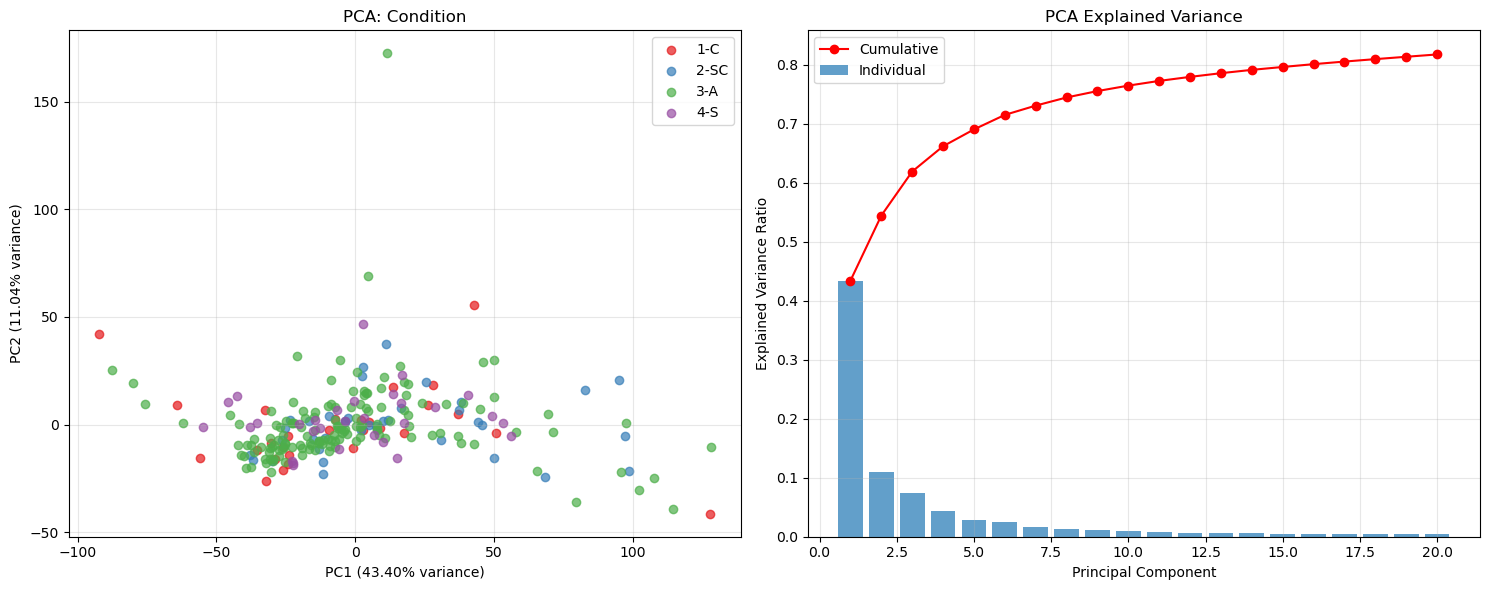


PCA Summary:
Number of unique labels: 4
Label distribution: {'1-C': 28, '2-SC': 37, '3-A': 145, '4-S': 30}
Total variance explained by first 2 components: 54.44%
Total variance explained by first 5 components: 69.03%
Total variance explained by first 10 components: 76.46%
Saved config copy to: MatrixExport_NP_A\20250722_122334\config.yaml


In [31]:
main("MatrixExport_NP_A.yaml")


Using clinical variable: Condition
Condition unique values: 4
Mapping created:
	0: '1-C'
	1: '2-SC'
	2: '3-A'
	3: '4-S'
Filtering out 0/240 samples with irrelevant labels.
Filtered out 0/1649 proteins with >20% missing values.
Starting PCA...
Original data shape: (240, 1649)
PCA result shape: (240, 240)
Explained variance ratio (first 10 components): [0.27043387 0.1501761  0.05532503 0.0419134  0.03275263 0.02912597
 0.02434051 0.02064643 0.01878814 0.01386576]
Cumulative explained variance (first 10 components): [0.27043387 0.42060998 0.47593501 0.5178484  0.55060103 0.57972699
 0.6040675  0.62471393 0.64350207 0.65736783]


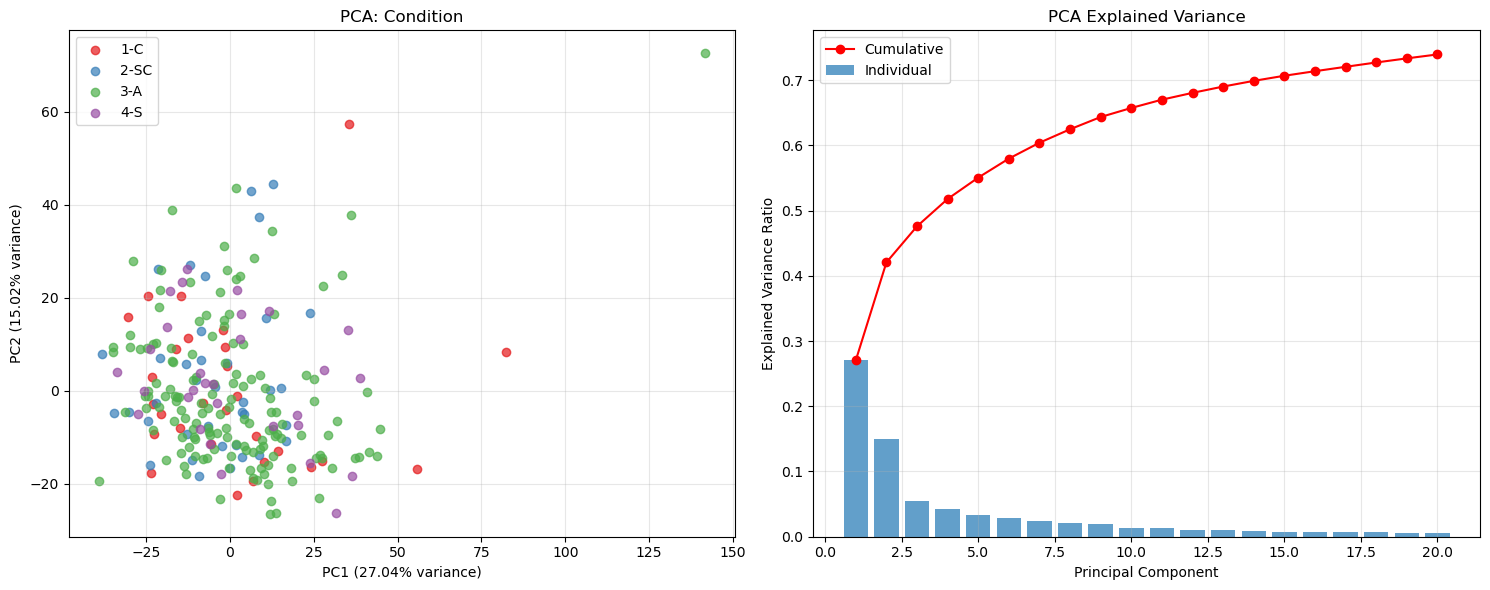


PCA Summary:
Number of unique labels: 4
Label distribution: {'1-C': 28, '2-SC': 37, '3-A': 145, '4-S': 30}
Total variance explained by first 2 components: 42.06%
Total variance explained by first 5 components: 55.06%
Total variance explained by first 10 components: 65.74%
Saved config copy to: MatrixExport_NP_B\20250722_122336\config.yaml


In [32]:
main("MatrixExport_NP_B.yaml")


In [10]:
protein_group_csv = "protein_group_df.csv"
clinical_csv = "clinical_df.csv"
protgroup_gene_map_json = "protgroup_gene_map.json"

missingness_thresh = 0.2
imputation_method = "mean"
fdr_thresh = 0.05  
var = "Condition"


# Load the data
protein_df = pd.read_csv(protein_group_csv, index_col=0)
clinical_df = pd.read_csv(clinical_csv, index_col=0)


binary_var, int_to_value = prepare_categorical_variable(
    clinical_df,
    var=var,
    #mapping=mapping,
    )

X, y = align_and_filter(protein_df, binary_var)
X = filter_features_by_missingness(X, threshold=missingness_thresh)
X = impute_missing_values(X, method=imputation_method)


# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# # Apply PCA
pca = PCA(n_components=min(X.shape[0], X.shape[1]))  # Use min to avoid dimension issues
pca_result = pca.fit_transform(scaled_data)
pca_result = pca.fit_transform(X)
# Create PCA DataFrame with correct dimensions
pca_df = pd.DataFrame(
    pca_result,
    index=X.index,
    columns=[f'PC{i+1}' for i in range(pca_result.shape[1])]
)



FileNotFoundError: [Errno 2] No such file or directory: 'protein_group_df.csv'

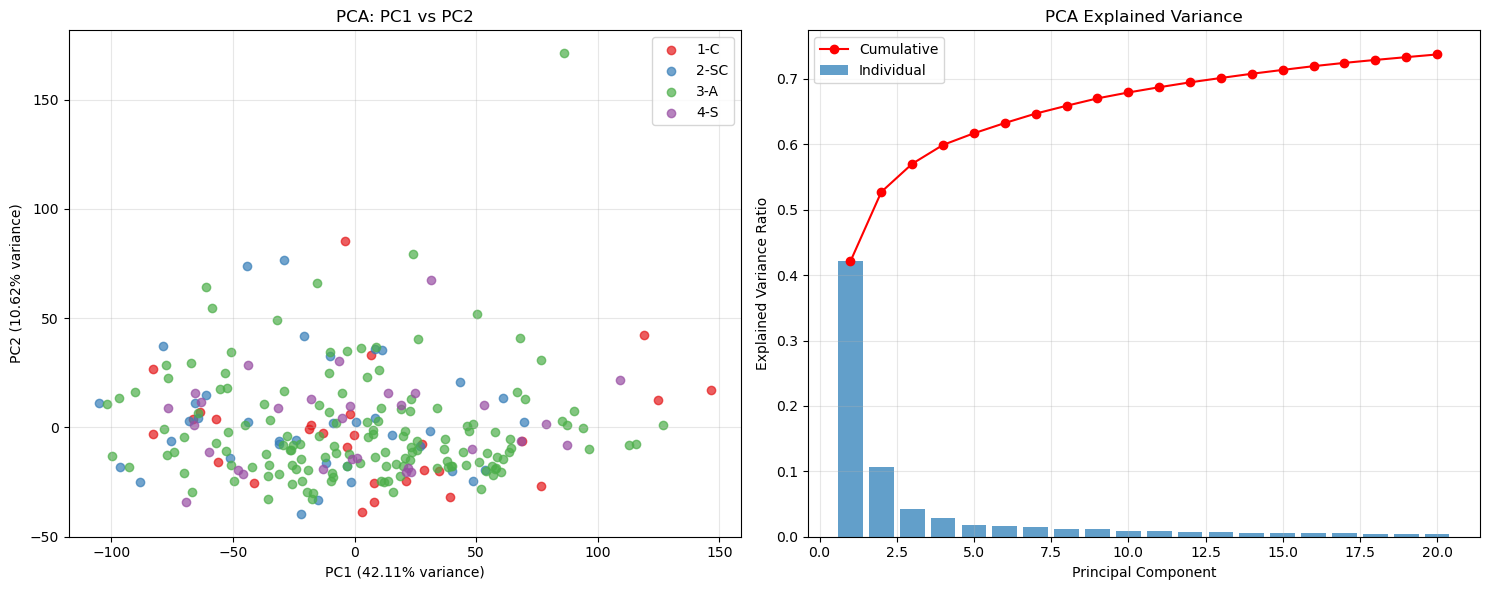


PCA Summary:
Number of unique labels: 4
Label distribution: {0: 28, 1: 37, 2: 145, 3: 30}
Total variance explained by first 2 components: 52.73%
Total variance explained by first 5 components: 61.70%
Total variance explained by first 10 components: 67.93%


In [9]:


# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: PCA scatter plot (PC1 vs PC2)
ax1 = axes[0]

# Get unique labels and create a color map
unique_labels = sorted(set(y))
colors = plt.cm.Set1(range(len(unique_labels)))  # Use Set1 colormap for distinct colors
color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

# Create scatter plot with colors based on labels
for label in unique_labels:
    mask = [y_val == label for y_val in y]
    ax1.scatter(pca_df['PC1'][mask], pca_df['PC2'][mask], 
               c=[color_map[label]], alpha=0.7, label=f'Label {label}')

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax1.set_title('PCA: PC1 vs PC2')
ax1.grid(True, alpha=0.3)

# Add legend with original mapping values
legend_labels = []
for label in unique_labels:
    # original_keys = [key for key, value in mapping.items() if value == label]
    # legend_label = f"{', '.join(original_keys)} (Label {label})"
    legend_label = int_to_value[label]
    legend_labels.append(legend_label)

# Update legend
handles, _ = ax1.get_legend_handles_labels()
ax1.legend(handles, legend_labels)

# Plot 2: Explained variance plot
ax2 = axes[1]
n_components_to_show = min(20, len(pca.explained_variance_ratio_))
components = range(1, n_components_to_show + 1)
variance_ratios = pca.explained_variance_ratio_[:n_components_to_show]
cumulative_variance = variance_ratios.cumsum()

ax2.bar(components, variance_ratios, alpha=0.7, label='Individual')
ax2.plot(components, cumulative_variance, 'ro-', label='Cumulative')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Explained Variance Ratio')
ax2.set_title('PCA Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nPCA Summary:")
print(f"Number of unique labels: {len(unique_labels)}")
print(f"Label distribution: {dict(pd.Series(y).value_counts().sort_index())}")
print(f"Total variance explained by first 2 components: {pca.explained_variance_ratio_[:2].sum():.2%}")
print(f"Total variance explained by first 5 components: {pca.explained_variance_ratio_[:5].sum():.2%}")
print(f"Total variance explained by first 10 components: {pca.explained_variance_ratio_[:10].sum():.2%}")


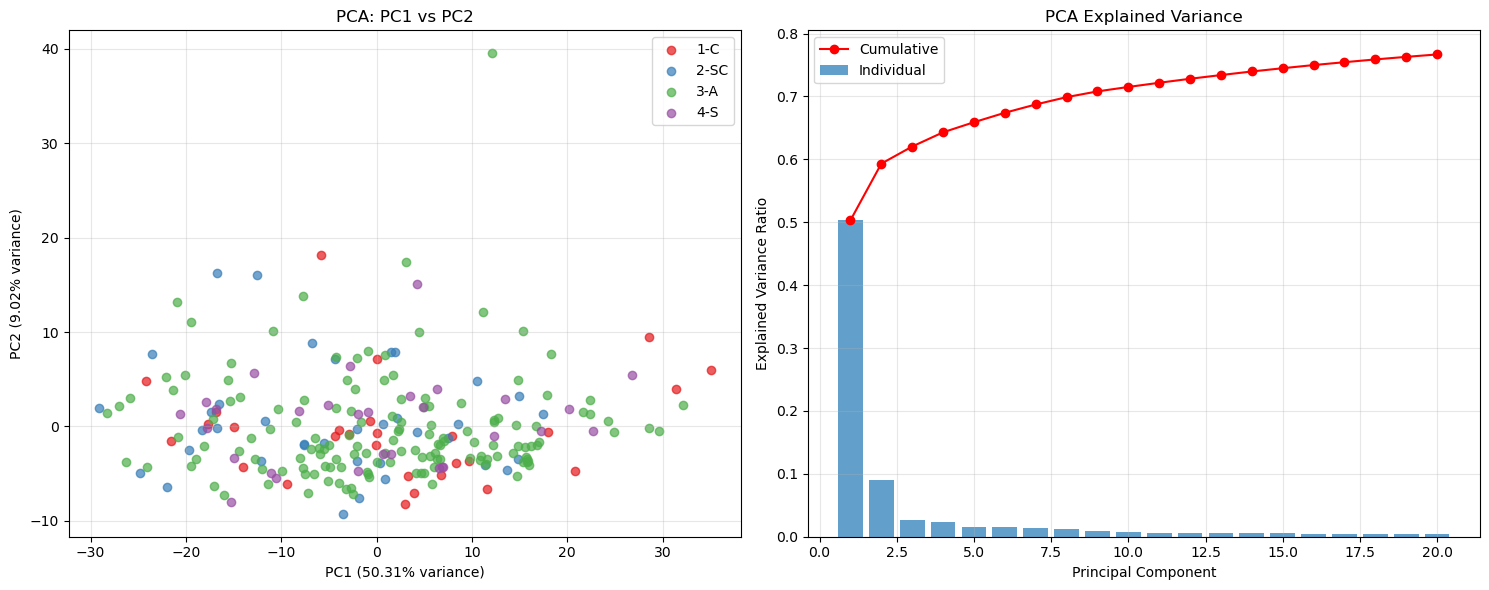


PCA Summary:
Number of unique labels: 4
Label distribution: {0: 28, 1: 37, 2: 145, 3: 30}
Total variance explained by first 2 components: 59.32%
Total variance explained by first 5 components: 65.91%
Total variance explained by first 10 components: 71.51%


In [18]:


# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: PCA scatter plot (PC1 vs PC2)
ax1 = axes[0]

# Get unique labels and create a color map
unique_labels = sorted(set(y))
colors = plt.cm.Set1(range(len(unique_labels)))  # Use Set1 colormap for distinct colors
color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

# Create scatter plot with colors based on labels
for label in unique_labels:
    mask = [y_val == label for y_val in y]
    ax1.scatter(pca_df['PC1'][mask], pca_df['PC2'][mask], 
               c=[color_map[label]], alpha=0.7, label=f'Label {label}')

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax1.set_title('PCA: PC1 vs PC2')
ax1.grid(True, alpha=0.3)

# Add legend with original mapping values
legend_labels = []
for label in unique_labels:
    # original_keys = [key for key, value in mapping.items() if value == label]
    # legend_label = f"{', '.join(original_keys)} (Label {label})"
    legend_label = int_to_value[label]
    legend_labels.append(legend_label)

# Update legend
handles, _ = ax1.get_legend_handles_labels()
ax1.legend(handles, legend_labels)

# Plot 2: Explained variance plot
ax2 = axes[1]
n_components_to_show = min(20, len(pca.explained_variance_ratio_))
components = range(1, n_components_to_show + 1)
variance_ratios = pca.explained_variance_ratio_[:n_components_to_show]
cumulative_variance = variance_ratios.cumsum()

ax2.bar(components, variance_ratios, alpha=0.7, label='Individual')
ax2.plot(components, cumulative_variance, 'ro-', label='Cumulative')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Explained Variance Ratio')
ax2.set_title('PCA Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nPCA Summary:")
print(f"Number of unique labels: {len(unique_labels)}")
print(f"Label distribution: {dict(pd.Series(y).value_counts().sort_index())}")
print(f"Total variance explained by first 2 components: {pca.explained_variance_ratio_[:2].sum():.2%}")
print(f"Total variance explained by first 5 components: {pca.explained_variance_ratio_[:5].sum():.2%}")
print(f"Total variance explained by first 10 components: {pca.explained_variance_ratio_[:10].sum():.2%}")
